# Key Factors in College Basketball Wins
This notebook builds and evaluates a random forest model to determine the characteristics that influence the win/loss % of mens college basketball teams. In the companion notebook "March_Madness_Win_Predictor", I utilize a logisitc regression model to predict which teams will win in any given March Madness bracket. Both notebooks rely on webscrapped data from https://www.sports-reference.com/cbb/.

# 1: Setup Environment

## Import Necessary Libraries & Packages


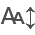

In [4]:
# pip install lxml
# pip install itables
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from scipy.stats import randint
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
import scipy.stats as ss
from sklearn.ensemble import RandomForestRegressor
import time
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import warnings
warnings.filterwarnings("ignore")

## Setup Global Variables

In [6]:
latest_season = int('2025')
SEED = 24
train_size = 0.75
CPUS = multiprocessing.cpu_count()

## Webscrape Advanced School Stats

In [8]:
schools = pd.DataFrame()
for year in range(2005, latest_season+1):
    print(f"Scrapping {year}")
    url = f"https://www.sports-reference.com/cbb/seasons/men/{year}-advanced-school-stats.html"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "lxml") 
    table = soup.find("table", id="adv_school_stats")
    if table is None:
        print(f"Data not found for {year}")
        break  # Move onto the next year
    tbody = table.find("tbody")
    rows = tbody.find_all("tr")
    columns = [th['data-stat'] for th in table.find("thead").find_all("th") if 'data-stat' in th.attrs]
    data = []
    for row in rows:
        if row.find("th", {"data-stat": "ranker"}) is None:
            continue
        row_data = []
        for col in columns:
            cell = row.find("td", {"data-stat": col}) or row.find("th", {"data-stat": col})
            row_data.append(cell.get_text(strip=True) if cell else None)
        data.append(row_data)
    df = pd.DataFrame(data, columns=columns)
    drop = ['', 'header_overall', 'header_conf', 'home', 'away', 'points',
            'header_school_advanced', 'ranker', 'DUMMY', 'g', 'wins', 'losses',
            'wins_conf', 'losses_conf', 'wins_home', 'losses_home', 'wins_visitor',
            'losses_visitor', 'pts', 'opp_pts']
    df = df.drop(columns=[col for col in drop if col in df.columns])
    df = df[df['school_name'] != 'School'].reset_index()
    floats = [col for col in df.columns if col not in ('school_name','index')]
    df[floats] = df[floats].apply(pd.to_numeric, errors='coerce').astype('float32')
    df['Season'] = year
    df['index'] = df['index'].astype('int16')
    schools = pd.concat([df, schools], ignore_index=True)  # Create a combined dataframe that includes each season and the corresponding data 
schools

Scrapping 2005
Scrapping 2006
Scrapping 2007
Scrapping 2008
Scrapping 2009
Scrapping 2010
Scrapping 2011
Scrapping 2012
Scrapping 2013
Scrapping 2014
Scrapping 2015
Scrapping 2016
Scrapping 2017
Scrapping 2018
Scrapping 2019
Scrapping 2020
Scrapping 2021
Scrapping 2022
Scrapping 2023
Scrapping 2024
Scrapping 2025


index        school_name  win_loss_pct        srs        sos       pace  \
0         0  Abilene Christian         0.500  -5.840000  -2.390000  71.099998   
1         1          Air Force         0.125  -8.070000   3.650000  64.699997   
2         2          AkronNCAA         0.800   3.220000  -3.750000  72.500000   
3         3        AlabamaNCAA         0.757  25.540001  16.139999  76.000000   
4         4        Alabama A&M         0.313 -20.520000  -9.930000  73.000000   
...     ...                ...           ...        ...        ...        ...   
7319    341       Wright State         0.500  -0.300000   0.370000        NaN   
7320    342            Wyoming         0.536   3.910000   3.910000        NaN   
7321    343             Xavier         0.586   6.970000   1.900000        NaN   
7322    344               Yale         0.407  -5.450000  -2.820000        NaN   
7323    345   Youngstown State         0.179 -14.400000  -0.710000        NaN   

         off_rtg  fta_per_fga_pct  fg3a_per_fga_pct  ts_pct    trb_pct  \
0      98.599998            0.361             0.262   0.523  50.099998   
1      95.000000            0.354             0.485   0.525  46.599998   
2     115.400002            0.261             0.459   0.579  52.299999   
3     118.500000            0.393             0.466   0.596  53.500000   
4      98.400002            0.375             0.410   0.504  49.500000   
...          ...              ...               ...     ...        ...   
7319         NaN            0.411             0.250   0.541  53.099998   
7320         NaN            0.444             0.305   0.530  53.299999   
7321         NaN            0.397             0.394   0.562  52.299999   
7322         NaN            0.406             0.256   0.514  49.400002   
7323         NaN            0.383             0.302   0.493  46.299999   

        ast_pct  stl_pct  blk_pct  efg_pct    tov_pct    orb_pct  ft_rate  \
0     51.400002     14.4      8.5    0.483  18.000000  31.799999    0.258   
1     62.900002      8.7      8.1    0.501  18.700001  22.700001    0.225   
2     58.599998     10.5      9.8    0.552  14.000000  32.700001    0.197   
3     55.400002      8.1     10.1    0.566  14.300000  33.700001    0.283   
4     54.299999     11.2     11.5    0.470  18.100000  35.099998    0.249   
...         ...      ...      ...      ...        ...        ...      ...   
7319  50.400002      NaN      3.2    0.509  18.799999        NaN    0.275   
7320  49.000000      NaN      9.0    0.494  19.400000        NaN    0.297   
7321  63.599998      NaN      6.0    0.523  18.000000        NaN    0.291   
7322  57.099998      NaN      4.9    0.480  18.000000        NaN    0.267   
7323  49.599998      NaN      7.2    0.458  20.400000        NaN    0.250   

      Season  
0       2025  
1       2025  
2       2025  
3       2025  
4       2025  
...      ...  
7319    2005  
7320    2005  
7321    2005  
7322    2005  
7323    2005  

[7324 rows x 19 columns]

## Data Cleaning

In [10]:
for row in schools[schools['srs'].isna()].index:
    season = schools.iloc[row, -1]
    replace = schools.groupby(['Season'])['srs'].median().loc[season]
    schools.iloc[row, 3] = replace  # Replace NA srs values with median for the season rather than dropping it
schools.drop(columns='sos', inplace=True)  # srs relies on sos. Drop sos to avoid multicollinearity
schools.dropna(subset=['pace'], inplace=True)  # 1600 null values. Don't want to over/under index teams towards the mean so just drop
assert not schools.isna().values.any()
schools['Season'] = schools['Season'].astype('category')
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5694 entries, 0 to 7302
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             5694 non-null   int16   
 1   school_name       5694 non-null   object  
 2   win_loss_pct      5694 non-null   float32 
 3   srs               5694 non-null   float32 
 4   pace              5694 non-null   float32 
 5   off_rtg           5694 non-null   float32 
 6   fta_per_fga_pct   5694 non-null   float32 
 7   fg3a_per_fga_pct  5694 non-null   float32 
 8   ts_pct            5694 non-null   float32 
 9   trb_pct           5694 non-null   float32 
 10  ast_pct           5694 non-null   float32 
 11  stl_pct           5694 non-null   float32 
 12  blk_pct           5694 non-null   float32 
 13  efg_pct           5694 non-null   float32 
 14  tov_pct           5694 non-null   float32 
 15  orb_pct           5694 non-null   float32 
 16  ft_rate           5694 non-nu

# Data Dictionary

| Column | Variable | Data type | Description |
|:-----:|:----------|:-----------|:-------------|
| 0 | index | int16 | Row number of given season | 
| 1 | school_name | object | School Name |
| 2 | win_loss_pct | float16 | Ratio of wins to losses in a season |
| 3 | srs | float16 | Simple Rating System: Takes into account average point differential and strength of schedule. The rating is denominated in points above/below average, where zero is average |
| 4 | sos | float16 | Strength of Schedule: The rating is denominated in points above/below average, where zero is average |
| 5 | pace | float16 | An estimate of school possessions per 40 minutes |
| 6 | off_rtg  | float16 | Offensive Rating: An estimate of points scored per 100 possessions  |
| 7 | fta_per_fga_pct | float16 | Free Throw Attempt Rate: Number of Free Throw Attempts Per Field Goal Attempt |
| 8 | fg3a_per_fga_pct | float16 | 3-Point Attempt Rate: Percentage of Field Goal Attempts from 3-Point Range |
| 9 | ts_pct | float16 | True Shooting Percentage: A measure of shooting efficiency |
| 10 | trb_pct | float16 | Total Rebound Percentage: An estimate of the percentage of available rebounds a player grabbed while they were on the floor |
| 11 | ast_pct | float16 | Assist Percentage: An estimate of the percentage of teammate field goals a player assisted while they were on the floor |
| 12 | stl_pct | float16 | Steal Percentage: An estimate of the percentage of opponent possessions that end with a steal by the player while they were on the floor |
| 13 | blk_pct | float16 | Block Percentage: An estimate of the percentage of opponent two-point field goal attempts blocked by the player while they were on the floor |
| 14 | efg_pct | float16 | Effective Field Goal Percentage: this statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal |
| 15 | tov_pct | float16 | Turnover Percentage: an estimate of turnovers per 100 plays |
| 16 | orb_pct | float16 | Offensive Rebound Percentage: an estimate of the percentage of available offensive rebounds a player grabbed while they were on the floor |
| 17 | ft_rate | float16 | Successful Free Throws Per Field Goal Attempt |
| 18 | season | int16 | Basketball Season (Represents the year March Madness happens) |

# 2: EDA

## Histogram Summary

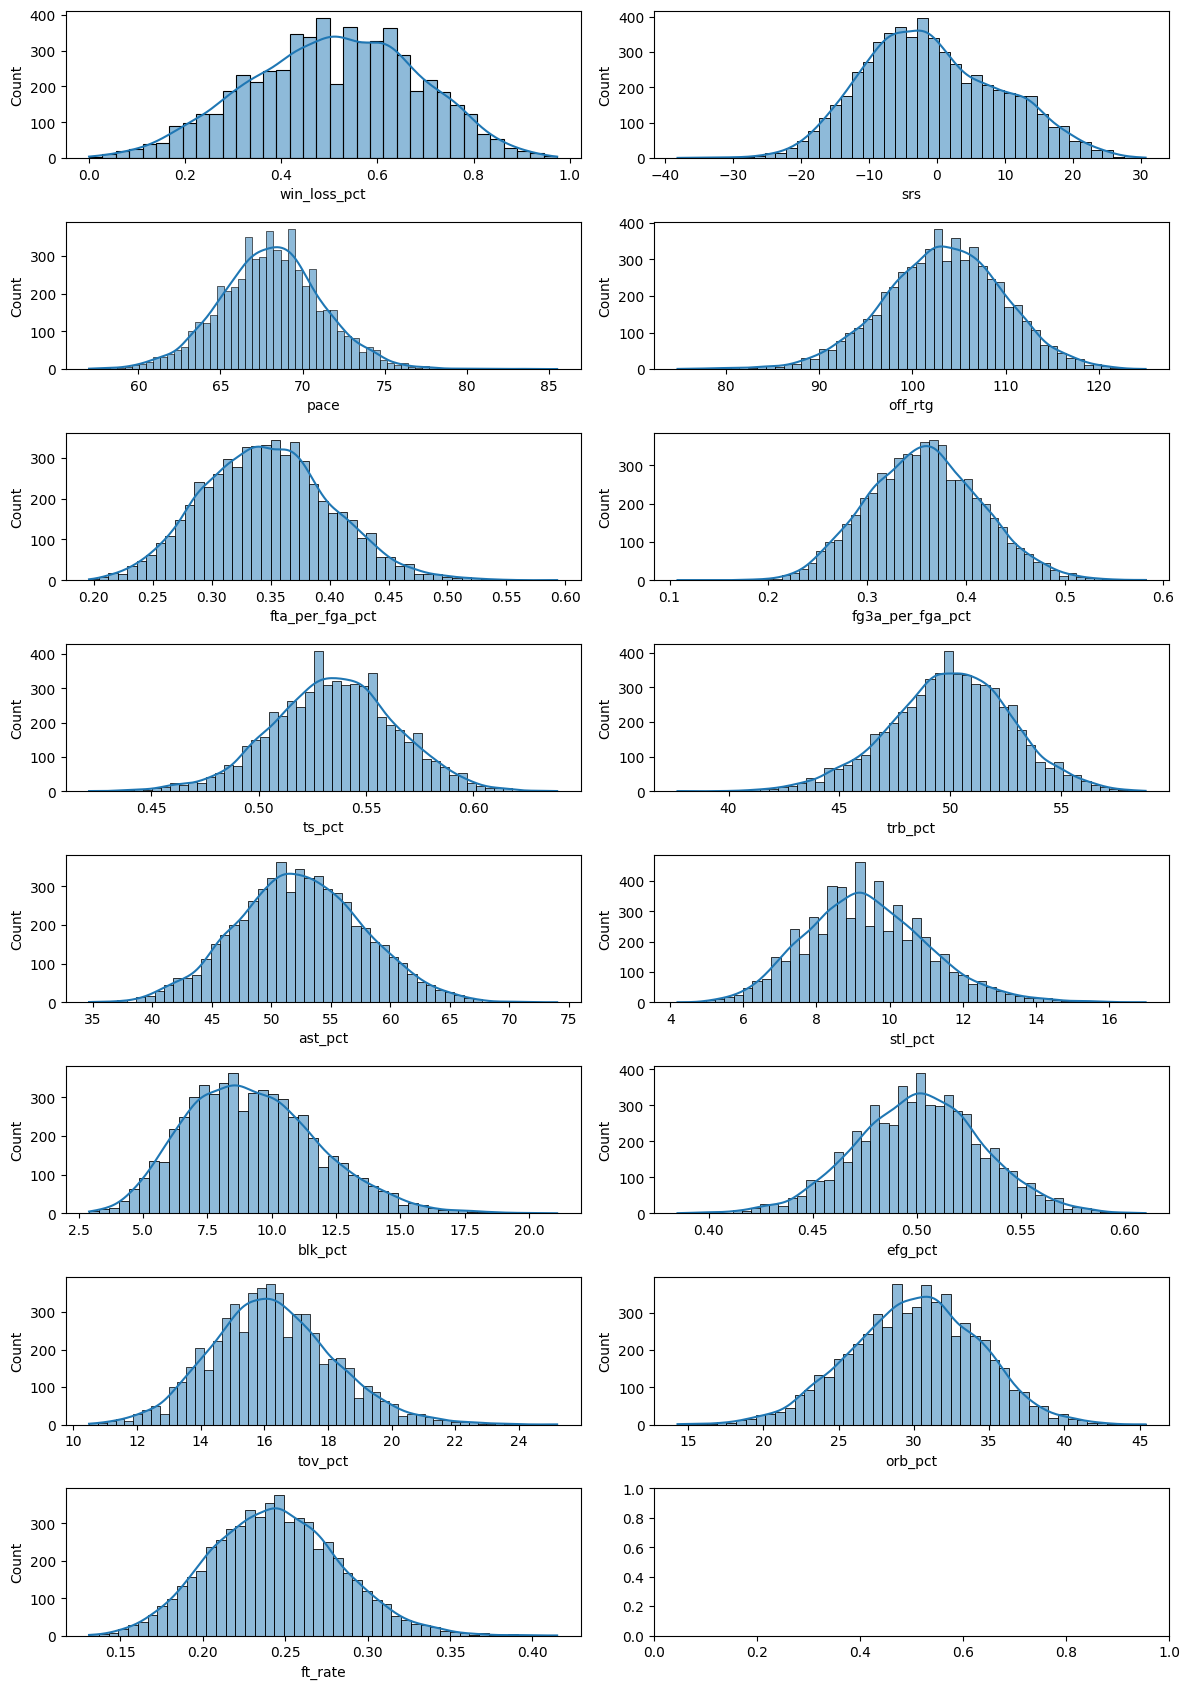

In [15]:
fig, ax = plt.subplots(8, 2, figsize=(12, 17))
ax = np.ravel(ax)
j = 0
for i in schools.columns:
    if i not in ('index', 'school_name', 'Season'):
        sns.histplot(schools.loc[:, i], ax=ax[j], kde=True)
        j += 1
    else:
        continue
plt.tight_layout()
plt.show()

## Boxplot Summary

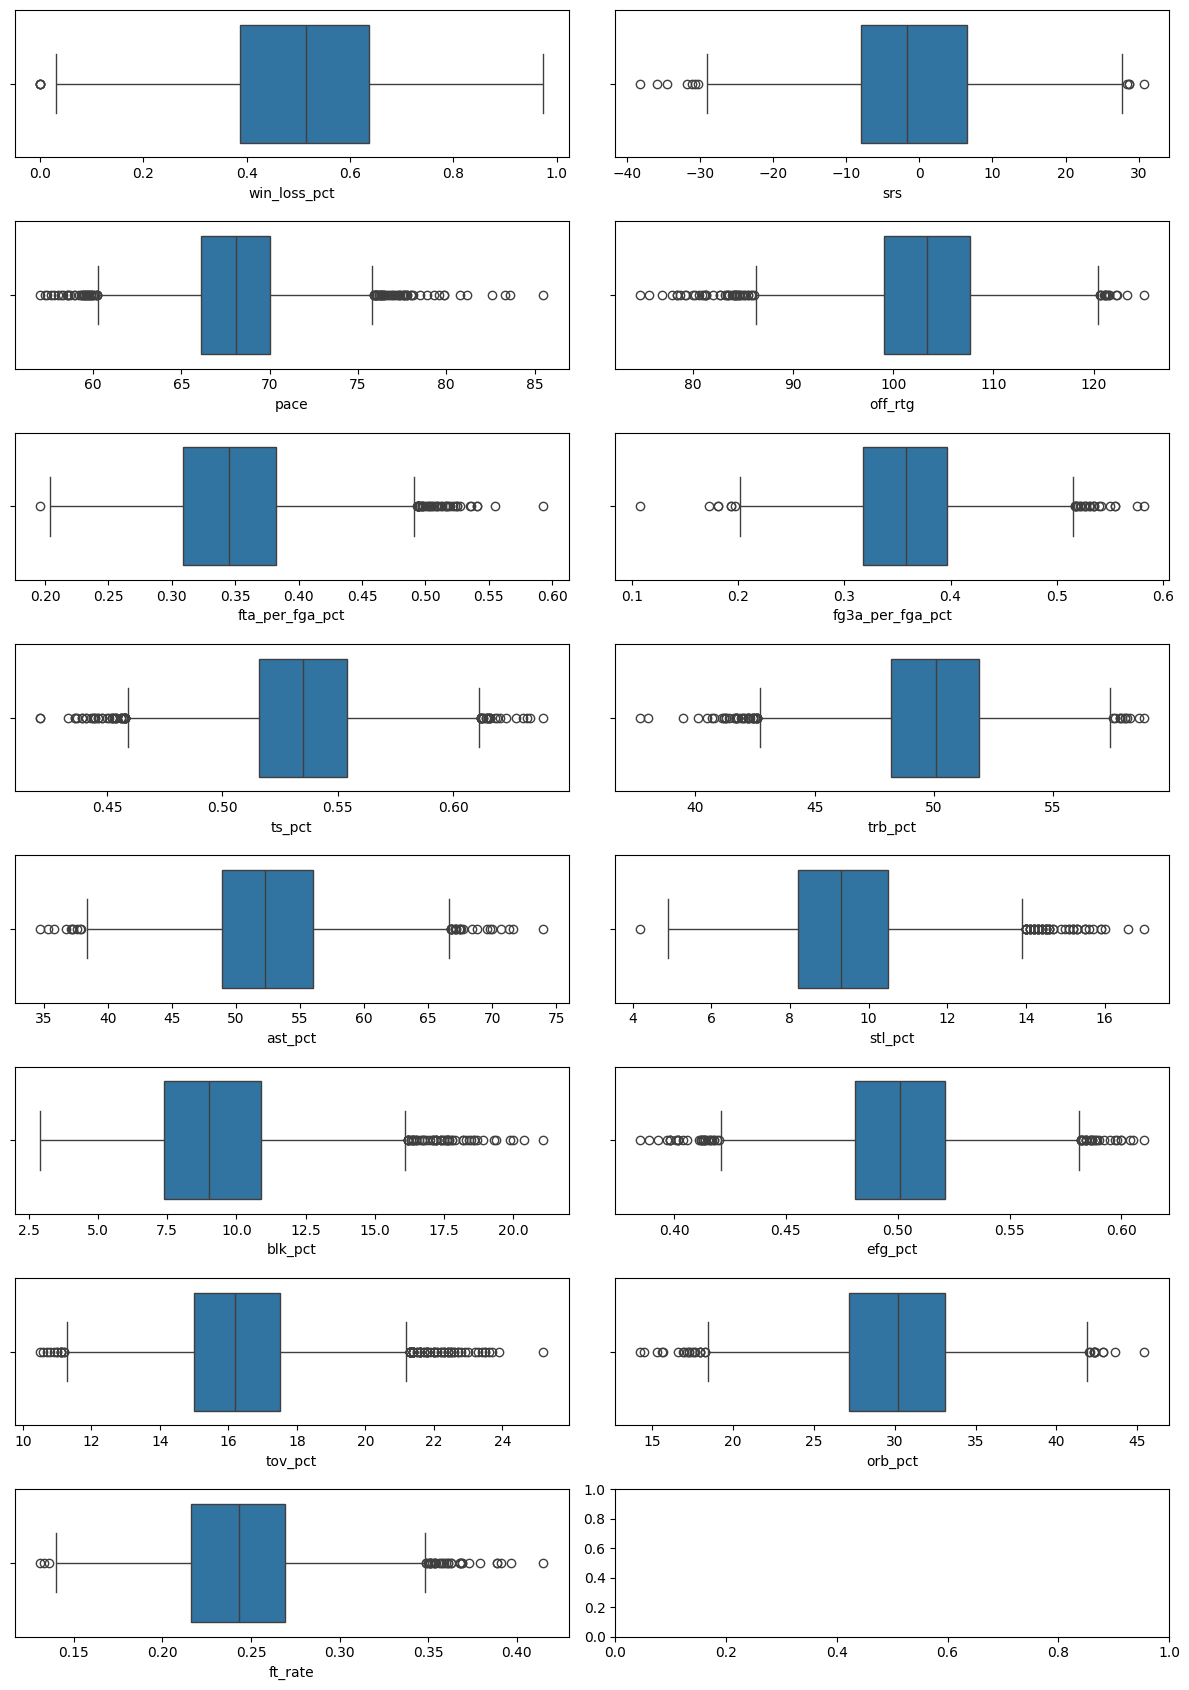

In [17]:
fig, ax = plt.subplots(8, 2, figsize=(12, 17))
ax = np.ravel(ax)
j = 0
for i in schools.columns:
    if i not in ('index', 'school_name', 'Season'):
        sns.boxplot(schools.loc[:, i], ax=ax[j], orient='h')
        j += 1
    else:
        continue
plt.tight_layout()
plt.show()

## Statistical Overview

In [19]:
describe_df = pd.DataFrame()
for i in schools.columns:
    if i not in ('index', 'school_name', 'Season'):
        describe_df[i] = schools[i].describe()
    else:
        continue
describe_df

win_loss_pct          srs         pace      off_rtg  fta_per_fga_pct  \
count   5694.000000  5694.000000  5694.000000  5694.000000      5694.000000   
mean       0.509274    -0.666270    68.087090   103.299721         0.347103   
std        0.173832    10.154338     3.134653     6.474222         0.054227   
min        0.000000   -38.169998    57.000000    74.800003         0.196000   
25%        0.387000    -7.980000    66.099998    99.099998         0.309000   
50%        0.515000    -1.682500    68.099998   103.400002         0.345000   
75%        0.636000     6.470000    70.000000   107.699997         0.382000   
max        0.974000    30.719999    85.500000   125.000000         0.593000   

       fg3a_per_fga_pct       ts_pct      trb_pct      ast_pct      stl_pct  \
count       5694.000000  5694.000000  5694.000000  5694.000000  5694.000000   
mean           0.358305     0.535012    49.991943    52.453915     9.387689   
std            0.057215     0.029060     2.764338     5.306452     1.687921   
min            0.108000     0.421000    37.700001    34.700001     4.200000   
25%            0.318000     0.516000    48.200001    48.900002     8.200000   
50%            0.358000     0.535000    50.099998    52.299999     9.300000   
75%            0.397000     0.554000    51.900002    56.000000    10.500000   
max            0.582000     0.639000    58.799999    74.000000    17.000000   

           blk_pct      efg_pct      tov_pct      orb_pct      ft_rate  
count  5694.000000  5694.000000  5694.000000  5694.000000  5694.000000  
mean      9.273025     0.501276    16.267300    30.086634     0.243934  
std       2.598611     0.030780     1.948122     4.265872     0.038931  
min       2.900000     0.385000    10.500000    14.300000     0.131000  
25%       7.400000     0.481000    15.000000    27.200001     0.216000  
50%       9.000000     0.501000    16.200001    30.200001     0.243000  
75%      10.900000     0.521000    17.500000    33.099998     0.269000  
max      21.100000     0.610000    25.200001    45.400002     0.415000

## Exploring Win/Loss %

### Median

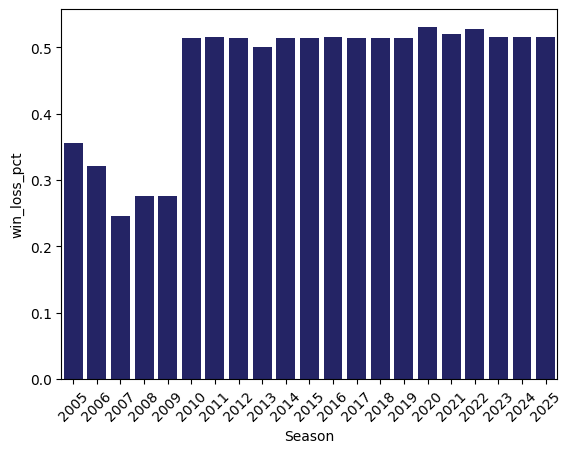

In [43]:
median_wins = schools.groupby('Season')['win_loss_pct'].median()
sns.barplot(data=median_wins, color="#191970")
plt.xticks(rotation=45)
plt.show()

### Mean

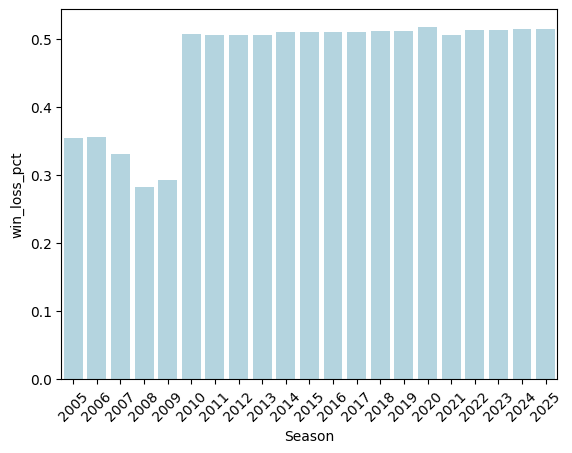

In [49]:
mean_wins = schools.groupby('Season')['win_loss_pct'].mean()
sns.barplot(data=mean_wins, color="lightblue")
plt.xticks(rotation=45)
plt.show()

### Best Each Season

In [26]:
(schools.loc[
             schools.groupby('Season')['win_loss_pct'].idxmax(),
            ['Season', 'school_name', 'win_loss_pct']
        ].sort_values('Season')
     )

Season               school_name  win_loss_pct
7269   2005  Texas A&M-Corpus Christi         0.714
6853   2006        North Dakota State         0.571
6628   2007               Utah Valley         0.759
6179   2008        North Dakota State         0.552
5950   2009               Utah Valley         0.607
5424   2010              KentuckyNCAA         0.921
5074   2011                KansasNCAA         0.921
4734   2012              KentuckyNCAA         0.950
4354   2013               GonzagaNCAA         0.914
4245   2014         Wichita StateNCAA         0.972
3688   2015              KentuckyNCAA         0.974
3528   2016             VillanovaNCAA         0.875
2951   2017               GonzagaNCAA         0.949
2827   2018              VirginiaNCAA         0.912
2476   2019              VirginiaNCAA         0.921
1895   2020                   Gonzaga         0.939
1544   2021               GonzagaNCAA         0.969
1277   2022          Murray StateNCAA         0.912
814    2023      Florida AtlanticNCAA         0.897
423    2024           ConnecticutNCAA         0.925
86     2025               FloridaNCAA         0.900

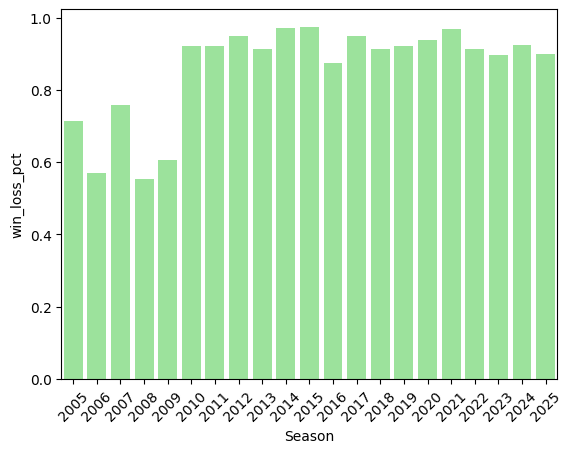

In [55]:
best_wins = (schools.loc[
             schools.groupby('Season')['win_loss_pct'].idxmax(),
            ['Season', 'win_loss_pct']
        ].sort_values('Season')
     )
sns.barplot(data=best_wins, x=best_wins['Season'], y=best_wins['win_loss_pct'], color="lightgreen")
plt.xticks(rotation=45)
plt.show()

## Analysis of EDA

Every single numerical variable roughly mimics a normal distribution. This indicates that the data source is well distributed and representative of mens college basketball teams. However, this doesn't negate the existence of outliers. Given the large sample size, nearly all of the numerical variables appear to have hundreds of outliers. Looking at the relationship between variables, a few inferences can be made about the nature of the outliers.

For instance, there are several right-skewed outliers for **pace** and left-skewed outliers for **off_rtg**. A higher pace means more possessions per 40 minutes which would likely lead to a lower off_rtg (points scored per 100 possessions) as a school would reach 100 possession much earlier in the game. A possible explanation is that schools in this scenario adhere to more aggressive strategies: catching more rebounds or attempting more 2-point field goals to mitigate turnovers.

Another relationship is **stl_pct** and **blk_pct**. A reasonable assumption is that schools are usually able to steal possession directly because they blocked opposing field goals. Several right-skewed outliers on both of these variables could indicate that schools in this scenario have a better defensive strategy in guarding opponents and playing close to the hoop. 

Aside from outliers, a very interesting observation is found in the win/loss percentage: there is a dramatic improvement in school wins between 2009-2010 and the scores remain high even today. Both the median and mean win/loss % went from around 29% in 2009 to 50% just a year later and for the past 15 years have hovered around 50%. Somehow within the span of a single season, the bottom 50% of teams collectively increased their chance of winning by over 70%. There doesn't appear to be any significant change in match scheduling, coaching, or the rules that would induce such a phenomenon. Although outside of the scope of this notebook, future researchers/analysts/enthusiasts should explore the factors affecting the stark shift in team performance after 2009.

# 3: Feature Engineering

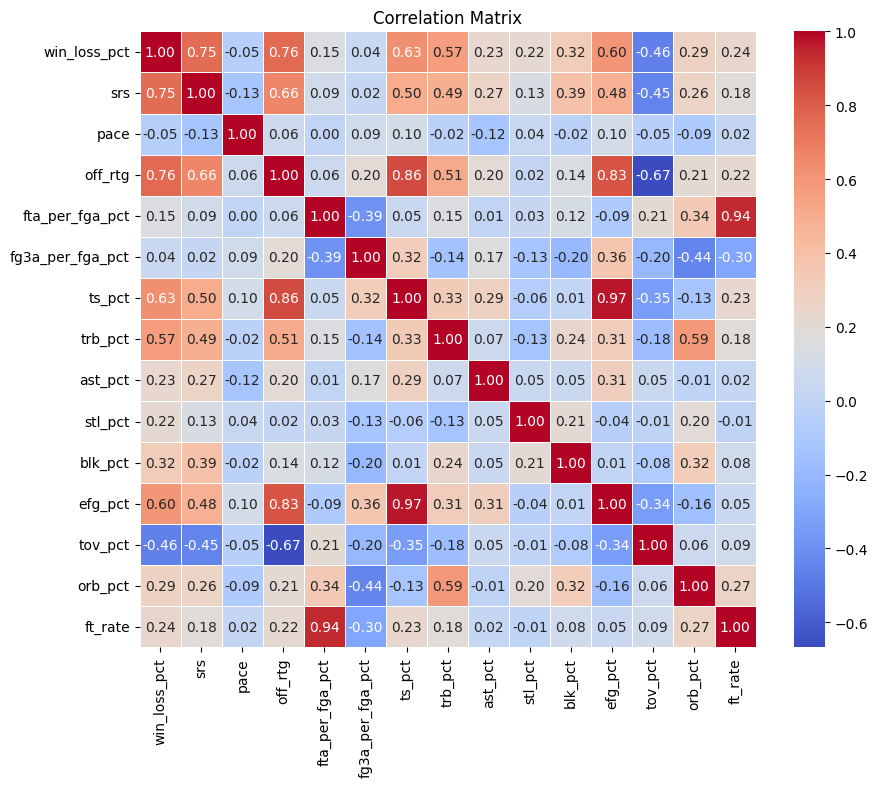

In [30]:
schools.drop(columns=['index', 'school_name', 'Season'], inplace=True)
corr_matrix = schools.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [31]:
schools.drop(columns=['fta_per_fga_pct','ts_pct','efg_pct'],inplace=True)  # over 80% correlation
print(f"Before dropping outliers: {len(schools)}")
for i in schools.columns:
    if i not in ('index','school_name','Season','win_loss_pct','srs'):
        highperc = schools[i].quantile(0.975)
        lowperc = schools[i].quantile(0.025)
        schools = schools[(schools[i] < highperc) & (schools[i] > lowperc)]  # Drop outliers
    else:
        continue
print(f"After dropping outliers: {len(schools)}")

Before dropping outliers: 5694
After dropping outliers: 3331


# 4: Random Forest

## Train-Test Split

In [34]:
df_train = schools.sample(frac=train_size, random_state=SEED)
train_idx = df_train.index
df_test = schools.loc[~(schools.index.isin(train_idx))]

In [35]:
assert set(df_test.index) & set(train_idx) == set()  # Ensure no overlapping rows in the train and test
assert set(df_test.index) | set(train_idx) == set(schools.index)  # Ensure all rows are either in train or test
assert (df_test.columns == df_train.columns).all()  # Ensure all the columns match between train and test
ks_dict = {}
for i in schools.columns:
    ks = ss.kstest(schools[i], df_train[i])
    ks_dict[i] = ks[1]
    assert ks_dict[i] > 0.05  # Ensure statistically similar distribution between train and test
ks_dict

{'win_loss_pct': np.float64(0.9851253417949472),
 'srs': np.float64(0.9975157618303954),
 'pace': np.float64(0.9999333172186682),
 'off_rtg': np.float64(0.999999988772651),
 'fg3a_per_fga_pct': np.float64(0.999999924835541),
 'trb_pct': np.float64(0.9999997907228367),
 'ast_pct': np.float64(0.999989674178147),
 'stl_pct': np.float64(0.9999999991445888),
 'blk_pct': np.float64(0.9986203658448423),
 'tov_pct': np.float64(0.999999989678225),
 'orb_pct': np.float64(0.9999941228871737),
 'ft_rate': np.float64(0.9835797592906854)}

## Default Model

In [37]:
start = time.time()  # Time the process
train_list = [col for col in schools.columns if col != 'win_loss_pct']
X_train = df_train[train_list]
y_train = df_train['win_loss_pct'] 
folds = 5
rf = RandomForestRegressor(random_state=SEED)
cv = cross_val_score(rf, X_train, y_train, cv=folds, scoring='r2', n_jobs=CPUS-1)
print(f"Fold scores:{cv}")
print(f"Mean score: {cv.mean():.3f}")
print(f"Default parameters:\n{rf.get_params()}")
end = time.time()  # Finish timing process
print(f"Elapsed time: {end - start:.2f} seconds")

Fold scores:[0.68473646 0.64746453 0.6543497  0.70258596 0.6806197 ]
Mean score: 0.674
Default parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 24, 'verbose': 0, 'warm_start': False}
Elapsed time: 3.22 seconds


## Cross Validated Model

In [39]:
start = time.time()  # Time the process
inner_folds = 5
outer_folds = 3
pgrid = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', 0.5, 0.3]
}
inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=SEED)
rf_rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=pgrid,
    scoring='r2',
    n_iter=75,
    cv=inner_cv,
    verbose=2,
    n_jobs=CPUS-1,
    random_state=SEED,
    error_score='raise'
)
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=SEED)
nested_scores = cross_val_score(
    rf_rs,
    X_train,
    y_train,
    cv=outer_cv,
    scoring='r2',
    n_jobs=CPUS-1
)
print(f"Nested CV scores: {nested_scores}")
print(f"Mean Nested CV: {np.mean(nested_scores):.3f}")
end = time.time()  # Finish timing process
print(f"Elapsed time: {(end - start)/60:.2f} minutes")

Nested CV scores: [0.66513004 0.68620103 0.6766847 ]
Mean Nested CV: 0.676
Elapsed time: 1.77 minutes


## Fitting the CV Model

In [41]:
rf_rs.fit(X_train, y_train)
print("Best parameters:", rf_rs.best_params_)
y_test = df_test['win_loss_pct']
X_test = df_test[train_list]
final_model = rf_rs.best_estimator_
print(f"R² on test set: {final_model.score(X_test, y_test):.4f}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best parameters: {'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 220}
R² on test set: 0.6504


## Most Important Features

In [43]:
top_features = pd.Series(final_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features.head(5)

srs        0.382495
off_rtg    0.270812
trb_pct    0.106477
stl_pct    0.049696
blk_pct    0.035107
dtype: float64

# 5: Analysis on ML Model

The final R² score for the random forest model is about 0.65. In terms of using this model as a secret technique for sports betting, the score is subpar and just slightly better than a coin toss. However, in terms of understanding how basketball metrics influence team wins, this score is insightful. Close to two-thirds of wins can be explained by material measures of performance: a percentage of possessions, field goal attempts, free throws, etc. The remaining one-third can be attributed to confounding variables like training, differences in player experience, starting roster, and more. 

Importantly, the features used in the model are lagging indicators and would constantly change during the season. It should be assumed that under the best conditions, with definitive performance metrics, a ML model can predict win percentage 65% of the time. The most important features being: the simple rating system, offensive rating, and total rebounds. From these findings we can infer that the teams with a higher likelihood of winning have a high simple rating (better teams recieve higher rating scores), a high offensive rating (more points increases the chance of winning), and a high total rebound percentage (reducing the time the opponents have possession).